In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [119]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [120]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    resolution = 50
    
    for i in range(resolution):
        threshold = i / resolution
#         threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    return tpr_list, fpr_list

In [121]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    

## 4-class classification evaluation with KS test

### Creating a synthetic dataset
Randomly generate some features

In [122]:
scale = 3.5
size = 500

In [123]:
class1_x = np.random.normal(loc = 10, scale = scale, size = size)
class1_y = np.random.normal(loc = 1, scale = scale, size = size)

In [124]:
class2_x = np.random.normal(loc = 1, scale = scale, size = size)
class2_y = np.random.normal(loc = 5, scale = scale, size = size)

In [125]:
class3_x = np.random.normal(loc = 10, scale = scale, size = size)
class3_y = np.random.normal(loc = 10, scale = scale, size = size)

In [126]:
class4_x = np.random.normal(loc = 5, scale = scale, size = size)
class4_y = np.random.normal(loc = 0, scale = scale, size = size)

In [127]:
df_class1 = pd.DataFrame({'x': class1_x, 'y': class1_y, 'class': 'Mondstadt'})
df_class2 = pd.DataFrame({'x': class2_x, 'y': class2_y, 'class': 'Liyue'})
df_class3 = pd.DataFrame({'x': class3_x, 'y': class3_y, 'class': 'Inazuma'})
df_class4 = pd.DataFrame({'x': class4_x, 'y': class4_y, 'class': 'Sumeru'})
df = df_class1.append(df_class2, ignore_index = True)
df = df.append(df_class3, ignore_index = True)
df = df.append(df_class4, ignore_index = True)

/var/folders/27/l6v26dbx0093xg448fxvxmpc0000gn/T/ipykernel_7704/2438781490.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_class1.append(df_class2, ignore_index = True)
/var/folders/27/l6v26dbx0093xg448fxvxmpc0000gn/T/ipykernel_7704/2438781490.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_class3, ignore_index = True)
/var/folders/27/l6v26dbx0093xg448fxvxmpc0000gn/T/ipykernel_7704/2438781490.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_class4, ignore_index = True)


<AxesSubplot:xlabel='x', ylabel='y'>

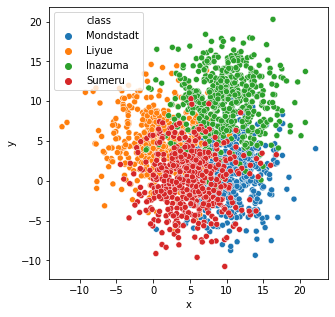

In [128]:
# Plot them to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'x', y = 'y', hue = 'class', data = df)

In [129]:
X = df[['x', 'y']]  # features
y = df['class']  # labels

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fit the model and make predictions

In [131]:
model = RandomForestClassifier(n_estimators = 50, criterion = 'gini')

In [132]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [133]:
y_pred = model.predict(X_test)

In [134]:
y_proba = model.predict_proba(X_test)

### ROC Curve: One vs Rest (OvR)

In [135]:
classes = model.classes_
classes

array(['Inazuma', 'Liyue', 'Mondstadt', 'Sumeru'], dtype=object)

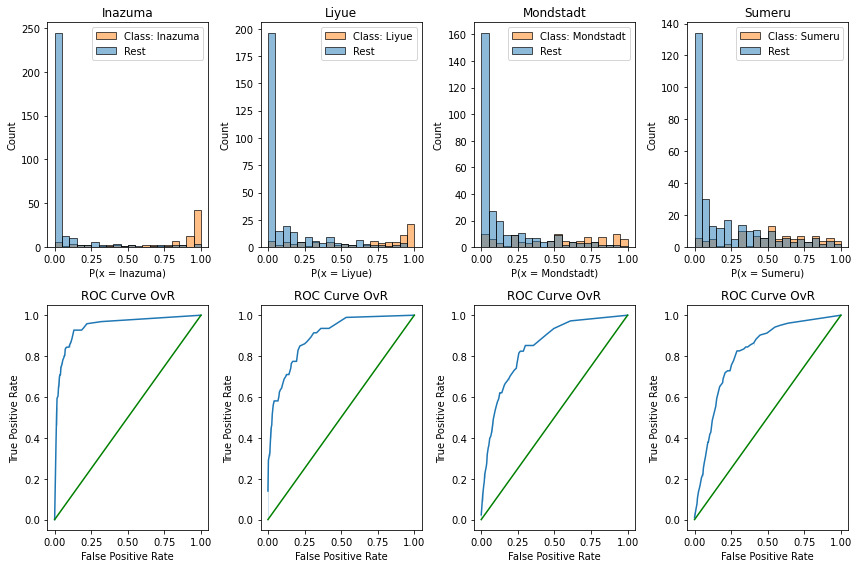

In [136]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12,8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    c = classes[i]
    
    # Prepare an auxiliary detaframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 4, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 4, i+5)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

Text(0.5, 1.0, 'ROC Curve OvR')

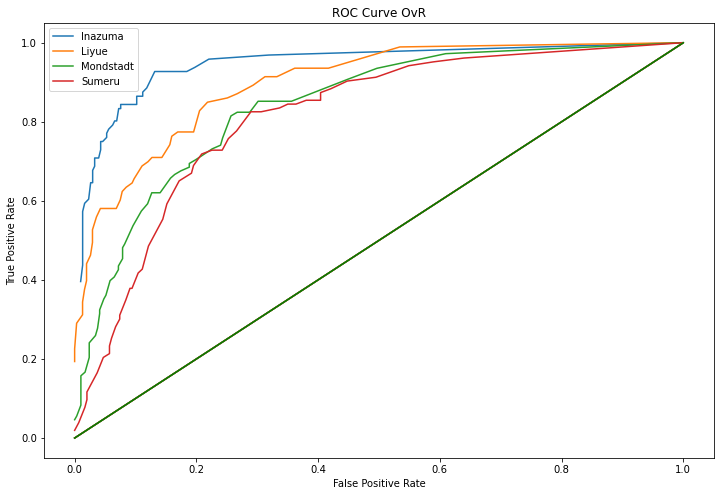

In [137]:
plt.figure(figsize = (12,8))
for i in range(len(classes)):
    c = classes[i]

    # Prepare an auxiliary detaframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plt.plot(fpr, tpr, label = c)
    
x = np.linspace(0, 1, 10)
Y = x
plt.plot(x, Y, color='g')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve OvR")

In [138]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

Inazuma ROC AUC OvR: 0.9457
Liyue ROC AUC OvR: 0.8969
Mondstadt ROC AUC OvR: 0.8410
Sumeru ROC AUC OvR: 0.8130
average ROC AUC OvR: 0.8742
